## Importing libraries

In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

2024-08-04 13:04:40.296034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-04 13:04:40.296182: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-04 13:04:40.504207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print(f"tensorflow version: {tf.__version__}")
print(f"tensorflow decision forest version: {tfdf.__version__}")

tensorflow version: 2.15.0
tensorflow decision forest version: 1.8.1


In [3]:
train_file_path = "/kaggle/input/house-prices-advanced-regression-techniques/train.csv"
dataset_df = pd.read_csv(train_file_path)
dataset_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
dataset_df.shape

(1460, 81)

In [5]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
print(dataset_df['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


/tmp/ipykernel_18/3360898667.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


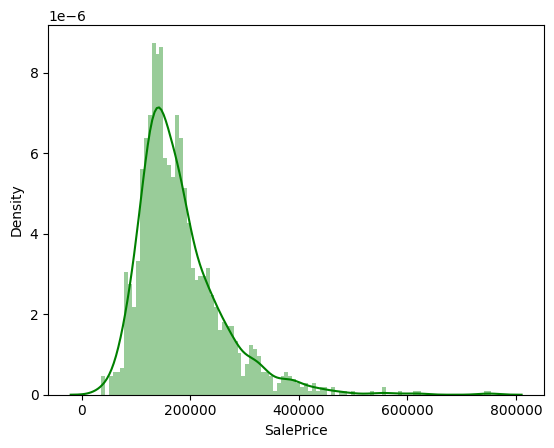

In [7]:
sns.distplot(dataset_df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

In [8]:
list(set(dataset_df.dtypes.tolist()))

[dtype('int64'), dtype('float64'), dtype('O')]

In [9]:
df_num = dataset_df.select_dtypes(include = ['int64', 'float64'])
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

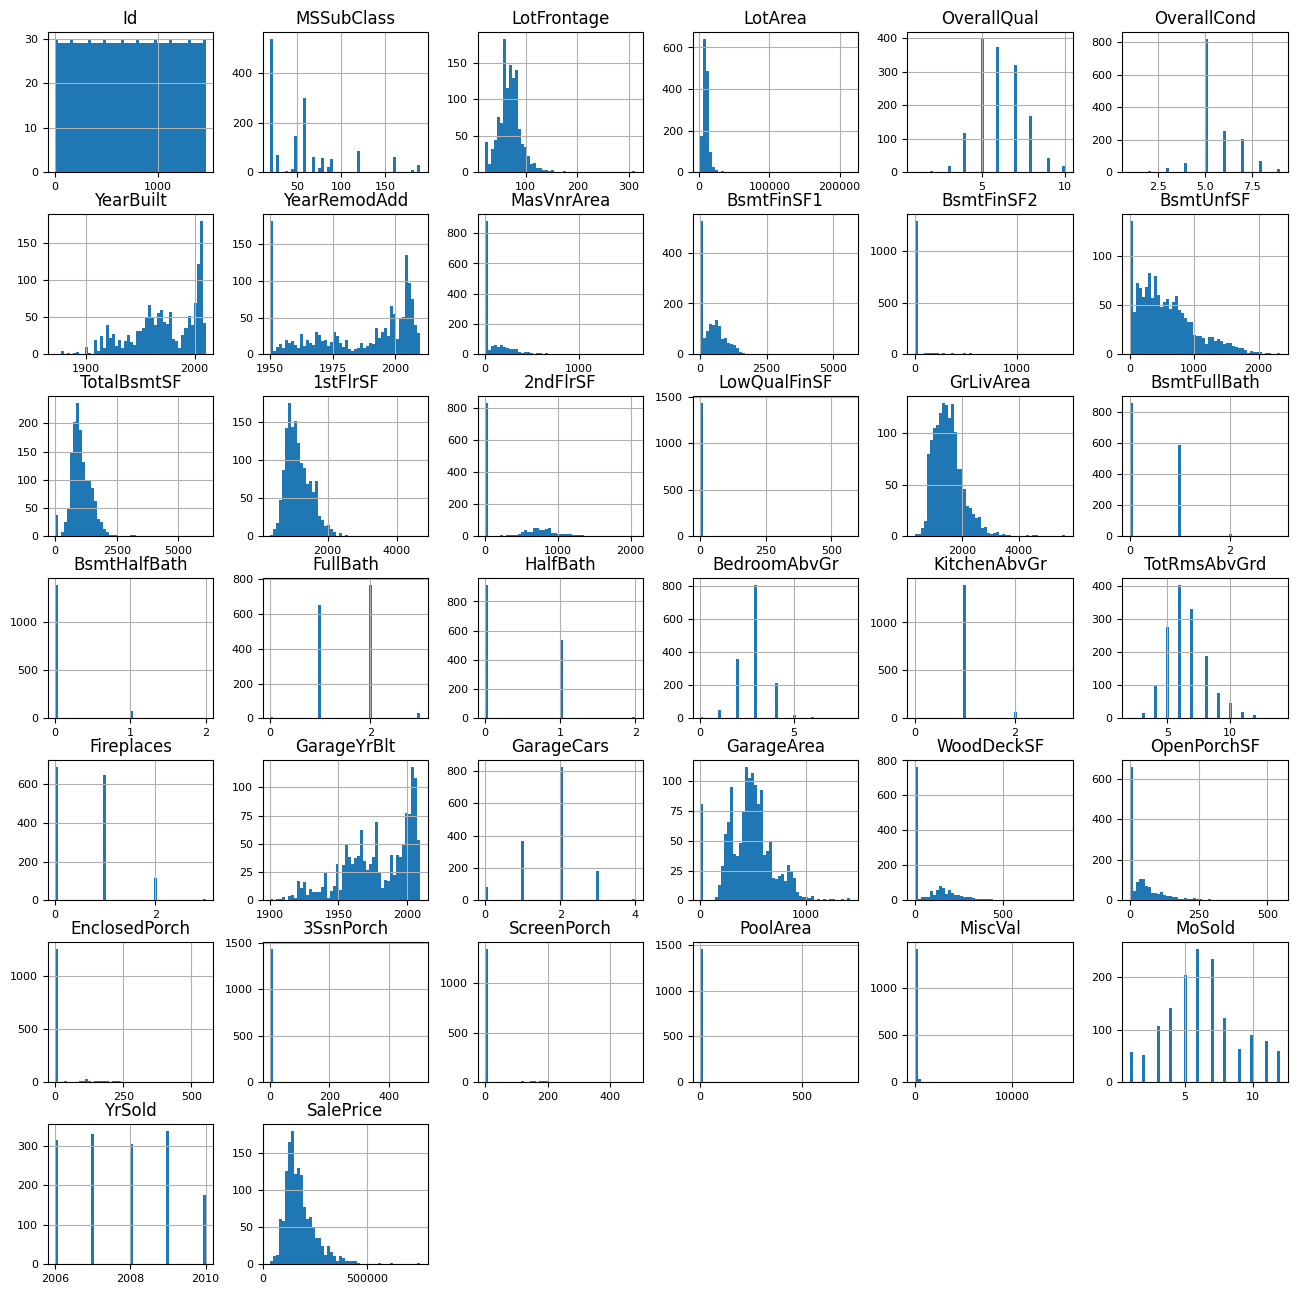

In [10]:
df_num.hist(figsize = (16, 16), bins = 50, xlabelsize = 8, ylabelsize = 8)

In [11]:
import numpy as np

def train_test_split(dataset, test_ratio = 0.30):
    test_indices = np.random.rand(len(dataset)) < test_ratio
#     print(test_indices)
    return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = train_test_split(dataset_df)
print(" {} examples in training, {} examples in test." .format(len(train_ds_pd), len(valid_ds_pd)))


 1011 examples in training, 449 examples in test.


In [12]:
label = "SalePrice"
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label = label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label = label, task =tfdf.keras.Task.REGRESSION)

In [13]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

In [14]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics = ["mse"])

Use /tmp/tmpa4w44rba as temporary training directory


In [15]:
rf.fit(x = train_ds)

Reading training dataset...
Training dataset read in 0:00:08.928902. Found 1011 examples.
Training model...


[INFO 24-08-04 13:05:22.3043 UTC kernel.cc:1233] Loading model from path /tmp/tmpa4w44rba/model/ with prefix 55a6866e4a274fe2


Model trained in 0:00:02.311344
Compiling model...


[INFO 24-08-04 13:05:22.7518 UTC decision_forest.cc:660] Model loaded with 300 root(s), 96148 node(s), and 74 input feature(s).
[INFO 24-08-04 13:05:22.7519 UTC abstract_model.cc:1344] Engine "RandomForestOptPred" built
[INFO 24-08-04 13:05:22.7519 UTC kernel.cc:1061] Use fast generic engine


Model compiled.


In [16]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

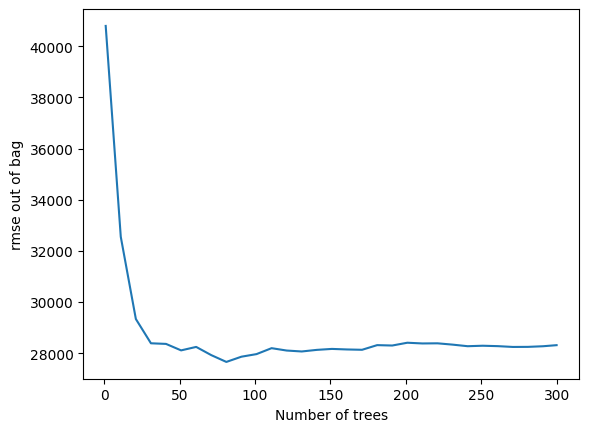

In [17]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("rmse out of bag")
plt.show()

In [18]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1011, accuracy=None, loss=None, rmse=28315.69818467587, ndcg=None, aucs=None, auuc=None, qini=None)

In [19]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 9s 9s/step - loss: 0.0000e+00 - mse: 1054719360.0000
loss: 0.0000
mse: 1054719360.0000


In [20]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 INV_MEAN_MIN_DEPTH
	 SUM_SCORE
	 NUM_AS_ROOT
	 NUM_NODES


In [21]:
inspector.variable_importances()["NUM_AS_ROOT"]


[("OverallQual" (1; #63), 110.0),
 ("ExterQual" (4; #22), 70.0),
 ("Neighborhood" (4; #60), 34.0),
 ("GarageCars" (1; #32), 26.0),
 ("YearBuilt" (1; #77), 20.0),
 ("BsmtQual" (4; #14), 8.0),
 ("GarageArea" (1; #31), 8.0),
 ("GrLivArea" (1; #38), 8.0),
 ("KitchenQual" (4; #45), 6.0),
 ("TotalBsmtSF" (1; #74), 6.0),
 ("1stFlrSF" (1; #0), 3.0),
 ("YearRemodAdd" (1; #78), 1.0)]

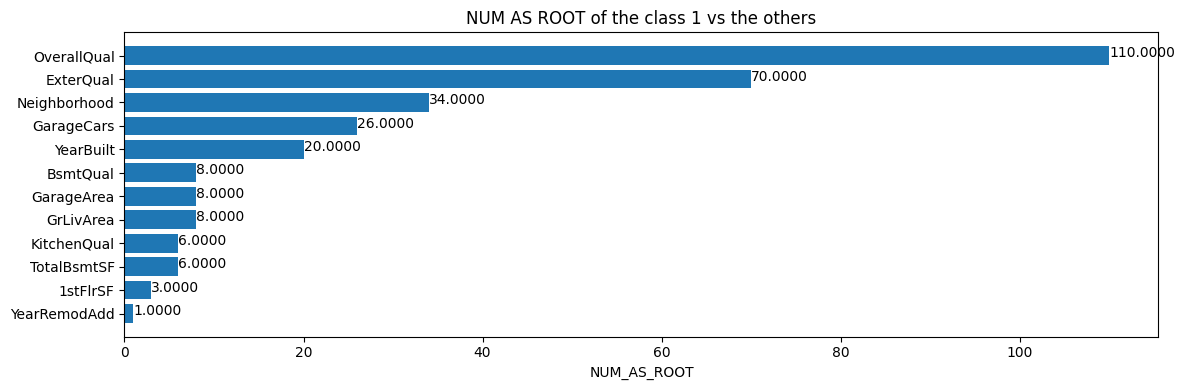

In [22]:
plt.figure(figsize=(12, 4))

# Mean decrease in AUC of the class 1 vs the others.
variable_importance_metric = "NUM_AS_ROOT"
variable_importances = inspector.variable_importances()[variable_importance_metric]

# Extract the feature name and importance values.
#
# `variable_importances` is a list of <feature, importance> tuples.
feature_names = [vi[0].name for vi in variable_importances]
feature_importances = [vi[1] for vi in variable_importances]
# The feature are ordered in decreasing importance value.
feature_ranks = range(len(feature_names))

bar = plt.barh(feature_ranks, feature_importances, label=[str(x) for x in feature_ranks])
plt.yticks(feature_ranks, feature_names)
plt.gca().invert_yaxis()

# TODO: Replace with "plt.bar_label()" when available.
# Label each bar with values
for importance, patch in zip(feature_importances, bar.patches):
  plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{importance:.4f}", va="top")

plt.xlabel(variable_importance_metric)
plt.title("NUM AS ROOT of the class 1 vs the others")
plt.tight_layout()
plt.show()

In [23]:
test_file_path = "/kaggle/input/house-prices-advanced-regression-techniques/test.csv"
test_data = pd.read_csv(test_file_path)
ids = test_data['Id']  # Store the IDs, but don't remove them from test_data

test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
    test_data,
    task=tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)

output = pd.DataFrame({
    'Id': ids,
    'SalePrice': preds.squeeze()
})

print(output.head())

2/2 [==============================] - 1s 23ms/step
     Id      SalePrice
0  1461  126811.062500
1  1462  153029.750000
2  1463  180446.531250
3  1464  185628.468750
4  1465  204126.171875


In [24]:
sample_submission_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('/kaggle/working/submission.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 24ms/step


,Id,SalePrice
0,1461,126811.062500
1,1462,153029.750000
2,1463,180446.531250
3,1464,185628.468750
4,1465,204126.171875
